In [3]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [4]:
%%time
import caffe

CPU times: user 223 ms, sys: 36.3 ms, total: 259 ms
Wall time: 279 ms


In [5]:
caffe_root = '/home/vadim/caffe/'

In [6]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()

#model_def = 'test/DIT/train2/dit/train_val_all_continue.prototxt'
model_def = 'human_car_deploy.prototxt'
model_weights = '_iter_800000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST) 

In [7]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print ('mean-subtracted values:', zip('BGR', mu))

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: <zip object at 0x7fbb27ba6dc0>


In [8]:

# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
#net.blobs['data'].reshape(50,        # batch size
#                          3,         # 3-channel (BGR) images
#                          224, 224)  # image size is 224
net.blobs['data'].reshape(104,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)


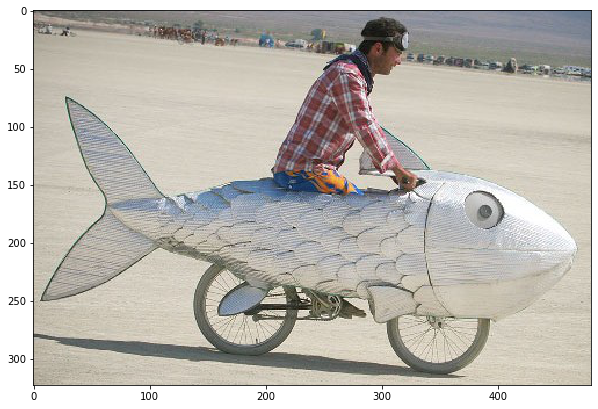

In [9]:
image = caffe.io.load_image(caffe_root + 'examples/images/fish-bike.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [10]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()
#print(output)
output_prob = output["prob"][0]  # the output probability vector for the first image in the batch
print ('predicted class is:', output_prob.argmax())

predicted class is: 2


In [11]:
# load labels
labels_file = 'labels.txt'

labels = np.loadtxt(labels_file, str, delimiter='\t')

print ('output label:', labels[output_prob.argmax()])

output label: human


In [12]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:2]  # reverse sort and take five largest items

print ('probabilities and labels:')
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


In [14]:
%timeit net.forward()

47.9 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.items():
    print (layer_name + '\t' + str(blob.data.shape))

data	(104, 3, 224, 224)
conv1/7x7_s2	(104, 64, 112, 112)
pool1/3x3_s2	(104, 64, 56, 56)
pool1/norm1	(104, 64, 56, 56)
conv2/3x3_reduce	(104, 64, 56, 56)
conv2/3x3	(104, 192, 56, 56)
conv2/norm2	(104, 192, 56, 56)
pool2/3x3_s2	(104, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(104, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(104, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(104, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(104, 192, 28, 28)
inception_3a/1x1	(104, 64, 28, 28)
inception_3a/3x3_reduce	(104, 96, 28, 28)
inception_3a/3x3	(104, 128, 28, 28)
inception_3a/5x5_reduce	(104, 16, 28, 28)
inception_3a/5x5	(104, 32, 28, 28)
inception_3a/pool	(104, 192, 28, 28)
inception_3a/pool_proj	(104, 32, 28, 28)
inception_3a/output	(104, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(104, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(104, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(104, 256, 28, 28)
inception_3a/output_i



    Now look at the parameter shapes. The parameters are exposed as another OrderedDict, net.params. We need to index the resulting values with either [0] for weights or [1] for biases.

    The param shapes typically have the form (output_channels, input_channels, filter_height, filter_width) (for the weights) and the 1-dimensional shape (output_channels,) (for the biases).



In [16]:
for layer_name, param in net.params.items():
    print (layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape))

conv1/7x7_s2	(64, 3, 7, 7) (64,)
conv2/3x3_reduce	(64, 64, 1, 1) (64,)
conv2/3x3	(192, 64, 3, 3) (192,)
inception_3a/1x1	(64, 192, 1, 1) (64,)
inception_3a/3x3_reduce	(96, 192, 1, 1) (96,)
inception_3a/3x3	(128, 96, 3, 3) (128,)
inception_3a/5x5_reduce	(16, 192, 1, 1) (16,)
inception_3a/5x5	(32, 16, 5, 5) (32,)
inception_3a/pool_proj	(32, 192, 1, 1) (32,)
inception_3b/1x1	(128, 256, 1, 1) (128,)
inception_3b/3x3_reduce	(128, 256, 1, 1) (128,)
inception_3b/3x3	(192, 128, 3, 3) (192,)
inception_3b/5x5_reduce	(32, 256, 1, 1) (32,)
inception_3b/5x5	(96, 32, 5, 5) (96,)
inception_3b/pool_proj	(64, 256, 1, 1) (64,)
inception_4a/1x1	(192, 480, 1, 1) (192,)
inception_4a/3x3_reduce	(96, 480, 1, 1) (96,)
inception_4a/3x3	(208, 96, 3, 3) (208,)
inception_4a/5x5_reduce	(16, 480, 1, 1) (16,)
inception_4a/5x5	(48, 16, 5, 5) (48,)
inception_4a/pool_proj	(64, 480, 1, 1) (64,)
inception_4b/1x1	(160, 512, 1, 1) (160,)
inception_4b/3x3_reduce	(112, 512, 1, 1) (112,)
inception_4b/3x3	(224, 112, 3, 3) (224

In [17]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

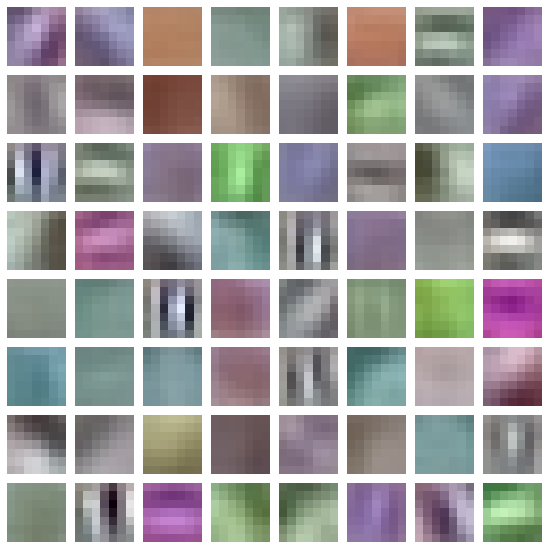

In [18]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1/7x7_s2'][0].data
#filters = net.params['inception_3a/3x3'][0].data[0, :36]
vis_square(filters.transpose(0, 2, 3, 1))
#vis_square(filters.transpose(0, 2, 1))

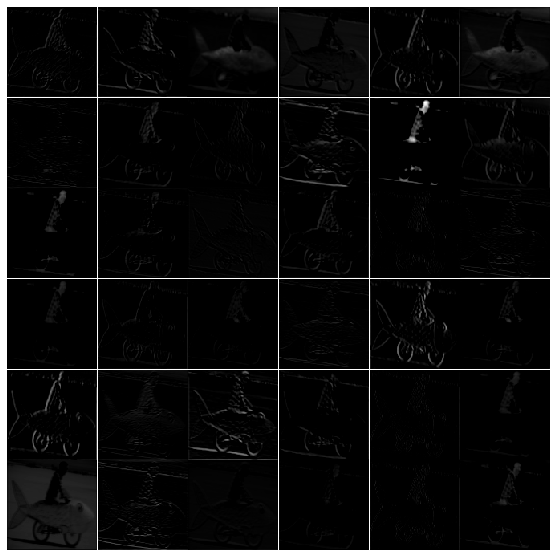

In [19]:
feat = net.blobs['conv1/7x7_s2'].data[0, :36]
vis_square(feat)

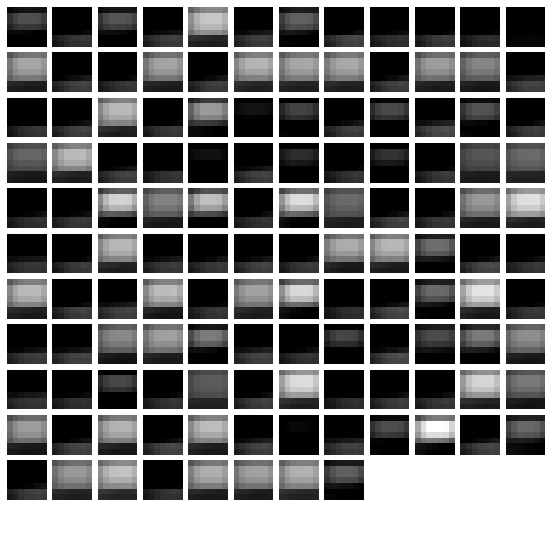

In [20]:
feat = net.blobs['inception_5b/pool_proj'].data[0]
vis_square(feat)

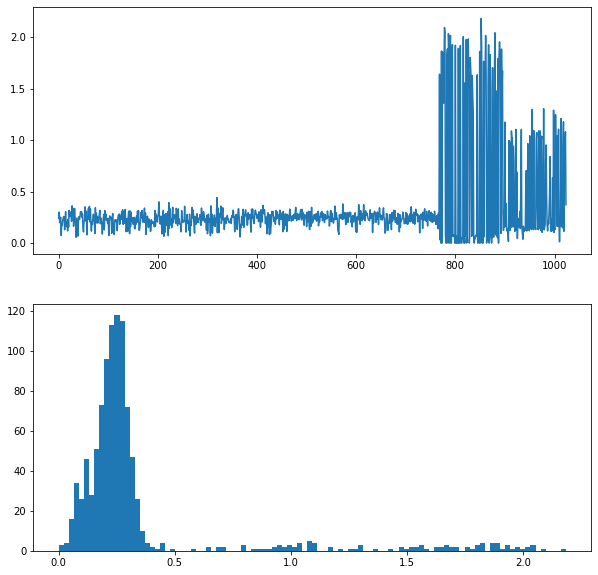

In [21]:
#show the output values and the histogram of the positive values
feat = net.blobs['pool5/7x7_s1'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

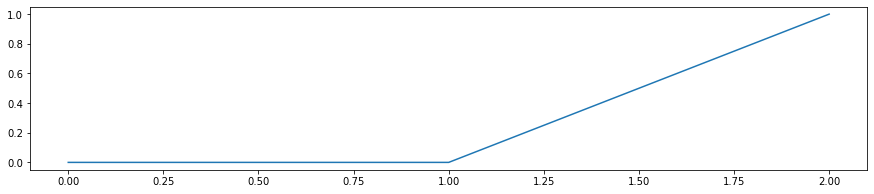

In [22]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

predicted class is: 2
output label: human


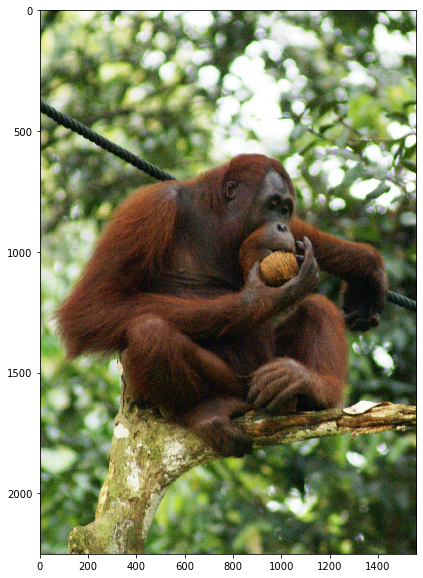

In [23]:
# download an image
my_image_url = "..."  # paste your URL here
# for example:
#my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
#!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:2]

plt.imshow(image)
print ('predicted class is:', output_prob.argmax())
#print ('probabilities and labels:')
#zip(output_prob[top_inds], labels[top_inds])
print ('output label:', labels[output_prob.argmax()])


## Testing


In [27]:
#try default net
caffe.set_device(0)
caffe.set_mode_gpu()
#62ms 55ms
#solver = caffe.AdamSolver('solver_all_continue.prototxt')

In [11]:
#77ms
solver = caffe.SGDSolver('solver_all_continue.prototxt')

In [ ]:
#%%time
#solver.net.forward()  # train net
#solver.test_nets[0].forward()  # test net (there can be more than one)

In [18]:
from pylab import *
%matplotlib inline

In [25]:
%%time
#1 min for SGD
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 3))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss3/loss3'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1/7x7_s2')
    output[it] = solver.test_nets[0].blobs['loss3/classifier'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print ('Iteration', it, 'testing...')
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['loss3/classifier'].data.argmax(1)
                           == solver.test_nets[0].blobs['loss3/classifier'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...


/home/vadim/anaconda3/envs/py2caffe/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 1min 8s, sys: 558 ms, total: 1min 8s
Wall time: 42.6 s


In [ ]:
#red accu blue loss

Text(0.5, 1.0, 'Test Accuracy: 0.00')

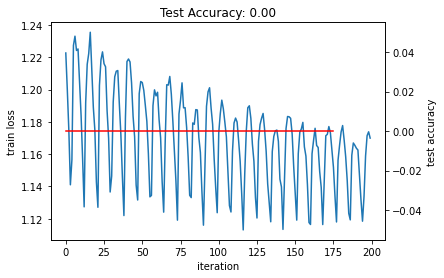

In [26]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

In [1]:
train_net_path = 'test/DIT/train2/dit/train_val_all_continue.prototxt'
test_net_path = 'human_car_deploy.prototxt'
solver_config_path = 'solver_all_continue.prototxt'


In [13]:
model_def = 'human_car_deploy.prototxt'
model_weights = '_iter_800000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)


In [14]:
### define solver
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()


In [15]:
solver = caffe.get_solver(solver_config_path)

In [16]:
solver.test_nets[0] = net

In [24]:
%%time
## solve

niter = 200  # EDIT HERE increase to train for longer
test_interval = niter / 10
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss3/loss3'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print ('Iteration', it, 'testing...')
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['prob'].data.argmax(1)
                           == solver.test_nets[0].blobs['loss3/classifier'].data)
        test_acc[it // test_interval] = correct / 1e4

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))

Iteration 0 testing...


/home/vadim/anaconda3/envs/py2caffe/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# def run_test(solver, test_iter):
#     '''
#     Tests the network on all test set and calculates the test accuracy
#     '''
#     correct = 0
#     batch_size_test =  solver.test_nets[0].blobs['data'].data.shape[0]

#     for test_it in range(test_iter):
#         #testing the network on all test set and calculate the test accuracy
#         solver.test_nets[0].forward()
#         correct += solver.test_nets[0].blobs['loss3/top-5'].data

#     acc = correct / test_iter
#     return acc 


In [ ]:
#run_test(caffe.SGDSolver('solver_all_continue.prototxt'), 200)


In [ ]:
#run_test(caffe.AdamSolver('solver_all_continue.prototxt'), 200)

In [24]:
categories=[x.strip() for x in open('labels.txt').readlines()]
print (categories)

['noise', 'car', 'human']


In [25]:
import caffe
import glob
import numpy

In [26]:
%%time
#this is very ineffective O(n^2)+complexity of network
for i, x in enumerate(categories):
    for j, y in enumerate(sorted(glob.glob('Data/test/{}/*'.format(x)))):
        net.blobs['data'].data[...] = transformer.preprocess('data',caffe.io.load_image(y))
        pred = net.forward()
        print(y, categories[np.argmax(pred['prob'])])

Data/test/noise/100093.JPEG noise
Data/test/noise/100132.JPEG noise
Data/test/noise/100386.JPEG noise
Data/test/noise/100422.JPEG noise
Data/test/noise/100426.JPEG noise
Data/test/noise/100508.JPEG noise
Data/test/noise/100517.JPEG noise
Data/test/noise/100598.JPEG noise
Data/test/noise/100627.JPEG noise
Data/test/noise/100750.JPEG noise
Data/test/noise/100762.JPEG noise
Data/test/noise/100901.JPEG noise
Data/test/noise/100923.JPEG noise
Data/test/noise/100931.JPEG noise
Data/test/noise/100946.JPEG noise
Data/test/noise/101035.JPEG noise
Data/test/noise/101153.JPEG noise
Data/test/noise/101264.JPEG noise
Data/test/noise/101305.JPEG noise
Data/test/noise/101411.JPEG noise
Data/test/noise/101500.JPEG noise
Data/test/noise/101533.JPEG noise
Data/test/noise/101605.JPEG noise
Data/test/noise/101609.JPEG noise
Data/test/noise/101733.JPEG noise
Data/test/noise/101767.JPEG noise
Data/test/noise/101800.JPEG noise
Data/test/noise/101849.JPEG noise
Data/test/noise/101855.JPEG noise
Data/test/nois

Data/test/noise/112410.JPEG noise
Data/test/noise/112524.JPEG noise
Data/test/noise/112545.JPEG noise
Data/test/noise/112640.JPEG noise
Data/test/noise/112702.JPEG noise
Data/test/noise/112725.JPEG noise
Data/test/noise/112782.JPEG noise
Data/test/noise/112869.JPEG noise
Data/test/noise/112912.JPEG noise
Data/test/noise/112953.JPEG noise
Data/test/noise/113106.JPEG noise
Data/test/noise/113140.JPEG noise
Data/test/noise/113149.JPEG noise
Data/test/noise/113219.JPEG noise
Data/test/noise/113240.JPEG noise
Data/test/noise/113254.JPEG noise
Data/test/noise/113309.JPEG noise
Data/test/noise/113314.JPEG noise
Data/test/noise/113337.JPEG noise
Data/test/noise/113443.JPEG noise
Data/test/noise/113485.JPEG noise
Data/test/noise/113751.JPEG noise
Data/test/noise/113797.JPEG noise
Data/test/noise/113904.JPEG noise
Data/test/noise/113974.JPEG noise
Data/test/noise/114086.JPEG noise
Data/test/noise/114156.JPEG noise
Data/test/noise/114163.JPEG noise
Data/test/noise/114205.JPEG noise
Data/test/nois

Data/test/car/110497.JPEG car
Data/test/car/110499.JPEG car
Data/test/car/110685.JPEG car
Data/test/car/110714.JPEG car
Data/test/car/110776.JPEG car
Data/test/car/110791.JPEG car
Data/test/car/110880.JPEG car
Data/test/car/110899.JPEG car
Data/test/car/110941.JPEG car
Data/test/car/110959.JPEG car
Data/test/car/111010.JPEG car
Data/test/car/111012.JPEG car
Data/test/car/111112.JPEG car
Data/test/car/111141.JPEG car
Data/test/car/111186.JPEG car
Data/test/car/111217.JPEG car
Data/test/car/111259.JPEG car
Data/test/car/111283.JPEG car
Data/test/car/111313.JPEG car
Data/test/car/111346.JPEG car
Data/test/car/111390.JPEG car
Data/test/car/111600.JPEG car
Data/test/car/111657.JPEG car
Data/test/car/111679.JPEG car
Data/test/car/111727.JPEG car
Data/test/car/111758.JPEG car
Data/test/car/111833.JPEG car
Data/test/car/112096.JPEG car
Data/test/car/112109.JPEG car
Data/test/car/112170.JPEG car
Data/test/car/112238.JPEG car
Data/test/car/112314.JPEG car
Data/test/car/112318.JPEG car
Data/test/

Data/test/human/108354.JPEG human
Data/test/human/108385.JPEG human
Data/test/human/108413.JPEG human
Data/test/human/108418.JPEG human
Data/test/human/108495.JPEG human
Data/test/human/108555.JPEG human
Data/test/human/108612.JPEG human
Data/test/human/108704.JPEG human
Data/test/human/108723.JPEG human
Data/test/human/108774.JPEG human
Data/test/human/108841.JPEG human
Data/test/human/108863.JPEG human
Data/test/human/108915.JPEG human
Data/test/human/108985.JPEG human
Data/test/human/109025.JPEG human
Data/test/human/109092.JPEG human
Data/test/human/109159.JPEG human
Data/test/human/109165.JPEG human
Data/test/human/109223.JPEG human
Data/test/human/109234.JPEG human
Data/test/human/109267.JPEG human
Data/test/human/109308.JPEG human
Data/test/human/109365.JPEG human
Data/test/human/109377.JPEG human
Data/test/human/109422.JPEG human
Data/test/human/109514.JPEG human
Data/test/human/109541.JPEG human
Data/test/human/109605.JPEG human
Data/test/human/109617.JPEG human
Data/test/huma

In [27]:
model_def = 'human_car_deploy.prototxt'
model_weights = 'test_iter_3500.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)


In [31]:
%timeit net.forward()

6.57 ms ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
%%time
#this is very ineffective O(n^2)+complexity of network
for i, x in enumerate(categories):
    for j, y in enumerate(sorted(glob.glob('Data/test/{}/*'.format(x)))):
        net.blobs['data'].data[...] = transformer.preprocess('data',caffe.io.load_image(y))
        pred = net.forward()
        print(y, categories[np.argmax(pred['prob'])])

Data/test/noise/100093.JPEG noise
Data/test/noise/100132.JPEG noise
Data/test/noise/100386.JPEG noise
Data/test/noise/100422.JPEG noise
Data/test/noise/100426.JPEG noise
Data/test/noise/100508.JPEG noise
Data/test/noise/100517.JPEG noise
Data/test/noise/100598.JPEG noise
Data/test/noise/100627.JPEG noise
Data/test/noise/100750.JPEG noise
Data/test/noise/100762.JPEG noise
Data/test/noise/100901.JPEG noise
Data/test/noise/100923.JPEG noise
Data/test/noise/100931.JPEG noise
Data/test/noise/100946.JPEG noise
Data/test/noise/101035.JPEG noise
Data/test/noise/101153.JPEG noise
Data/test/noise/101264.JPEG noise
Data/test/noise/101305.JPEG noise
Data/test/noise/101411.JPEG noise
Data/test/noise/101500.JPEG noise
Data/test/noise/101533.JPEG noise
Data/test/noise/101605.JPEG noise
Data/test/noise/101609.JPEG noise
Data/test/noise/101733.JPEG noise
Data/test/noise/101767.JPEG noise
Data/test/noise/101800.JPEG noise
Data/test/noise/101849.JPEG noise
Data/test/noise/101855.JPEG noise
Data/test/nois

Data/test/noise/113149.JPEG noise
Data/test/noise/113219.JPEG noise
Data/test/noise/113240.JPEG noise
Data/test/noise/113254.JPEG noise
Data/test/noise/113309.JPEG noise
Data/test/noise/113314.JPEG noise
Data/test/noise/113337.JPEG noise
Data/test/noise/113443.JPEG noise
Data/test/noise/113485.JPEG noise
Data/test/noise/113751.JPEG noise
Data/test/noise/113797.JPEG noise
Data/test/noise/113904.JPEG noise
Data/test/noise/113974.JPEG noise
Data/test/noise/114086.JPEG noise
Data/test/noise/114156.JPEG noise
Data/test/noise/114163.JPEG noise
Data/test/noise/114205.JPEG noise
Data/test/noise/114271.JPEG noise
Data/test/noise/114371.JPEG noise
Data/test/noise/114426.JPEG noise
Data/test/noise/114509.JPEG noise
Data/test/noise/114573.JPEG noise
Data/test/noise/114597.JPEG noise
Data/test/noise/114672.JPEG noise
Data/test/noise/114714.JPEG noise
Data/test/noise/114726.JPEG noise
Data/test/noise/114732.JPEG noise
Data/test/noise/114804.JPEG noise
Data/test/noise/114805.JPEG noise
Data/test/nois

Data/test/car/111217.JPEG car
Data/test/car/111259.JPEG car
Data/test/car/111283.JPEG car
Data/test/car/111313.JPEG car
Data/test/car/111346.JPEG car
Data/test/car/111390.JPEG car
Data/test/car/111600.JPEG car
Data/test/car/111657.JPEG car
Data/test/car/111679.JPEG car
Data/test/car/111727.JPEG car
Data/test/car/111758.JPEG car
Data/test/car/111833.JPEG car
Data/test/car/112096.JPEG car
Data/test/car/112109.JPEG car
Data/test/car/112170.JPEG car
Data/test/car/112238.JPEG car
Data/test/car/112314.JPEG car
Data/test/car/112318.JPEG car
Data/test/car/112329.JPEG car
Data/test/car/112410.JPEG car
Data/test/car/112524.JPEG car
Data/test/car/112545.JPEG car
Data/test/car/112640.JPEG car
Data/test/car/112702.JPEG car
Data/test/car/112725.JPEG car
Data/test/car/112782.JPEG car
Data/test/car/112869.JPEG car
Data/test/car/112912.JPEG car
Data/test/car/112953.JPEG car
Data/test/car/113106.JPEG car
Data/test/car/113140.JPEG car
Data/test/car/113149.JPEG car
Data/test/car/113219.JPEG car
Data/test/

Data/test/human/109092.JPEG human
Data/test/human/109159.JPEG human
Data/test/human/109165.JPEG human
Data/test/human/109223.JPEG human
Data/test/human/109234.JPEG human
Data/test/human/109267.JPEG human
Data/test/human/109308.JPEG human
Data/test/human/109365.JPEG human
Data/test/human/109377.JPEG human
Data/test/human/109422.JPEG human
Data/test/human/109514.JPEG human
Data/test/human/109541.JPEG human
Data/test/human/109605.JPEG human
Data/test/human/109617.JPEG human
Data/test/human/109659.JPEG human
Data/test/human/109695.JPEG human
Data/test/human/109782.JPEG human
Data/test/human/109784.JPEG human
Data/test/human/109854.JPEG human
Data/test/human/109856.JPEG human
Data/test/human/109928.JPEG human
Data/test/human/109939.JPEG human
Data/test/human/109947.JPEG human
Data/test/human/109961.JPEG human
Data/test/human/109966.JPEG human
Data/test/human/110047.JPEG human
Data/test/human/110069.JPEG human
Data/test/human/110112.JPEG human
Data/test/human/110168.JPEG human
Data/test/huma

In [33]:
print(len(sorted(glob.glob('Data/test/{}/*'.format(x)))))

300


In [34]:
print(net.blobs['data'].data.shape)

(10, 3, 224, 224)


In [35]:
print(categories[np.argmax(pred['prob'][0])])


human


In [36]:
np.argmax(pred['prob'], axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [37]:
print(pred['prob'])

[[1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]
 [1.2132027e-07 3.8373923e-07 9.9999952e-01]]


In [38]:
len(pred['prob'])

10

In [41]:
print(in_shape[0])

10


In [40]:
import PIL
fnames = sorted(glob.glob('Data/test/{}/*'.format(x)))
bs = 104 #len(fnames)  # batch size
in_shape = net.blobs['data'].data.shape
#in_shape[0] = bs # set new batch size
net.blobs['data'].reshape(*in_shape)
net.reshape()
for i, x in enumerate(categories):
    for bs, f in enumerate(sorted(glob.glob('Data/test/{}/*'.format(x)))):
        img = caffe.io.load_image(f)
        # scale all images to 224x224
        #img = img.resize((224,224), PIL.Image.ANTIALIAS)
        img = numpy.array(img).astype(numpy.float32)

        transformed_image = transformer.preprocess('data', img)
        #print transformed_image.shape

        # put the image into i-th place in batch
        net.blobs['data'].data[i,:,:,:] = transformed_image

# after reading all images into batch, forward once:
net.forward()
#pred index need to be iterated
j = 0
for i, x in enumerate(categories):
    for file_index, f in enumerate(sorted(glob.glob('Data/test/{}/*'.format(x)))):
        if j == 103:
            j=0
        print(f, categories[np.argmax(pred['prob'][j])])
        j = j+1
#out_images = np.array(X_train)[indices.astype(int)]            

Data/test/noise/100093.JPEG noise
Data/test/noise/100132.JPEG car
Data/test/noise/100386.JPEG human
Data/test/noise/100422.JPEG human
Data/test/noise/100426.JPEG human
Data/test/noise/100508.JPEG human
Data/test/noise/100517.JPEG human
Data/test/noise/100598.JPEG human
Data/test/noise/100627.JPEG human
Data/test/noise/100750.JPEG human


IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
%%time
#enum folder x separate file i=index
for i, x in enumerate(categories):
    for j, y in enumerate(sorted(glob.glob('dataset/JPEGImages/*'.format(x)))):
        net.blobs['data'].data[...] = transformer.preprocess('data',caffe.io.load_image(y))
        pred = net.forward()
        print(y, categories[np.argmax(pred['prob'])])

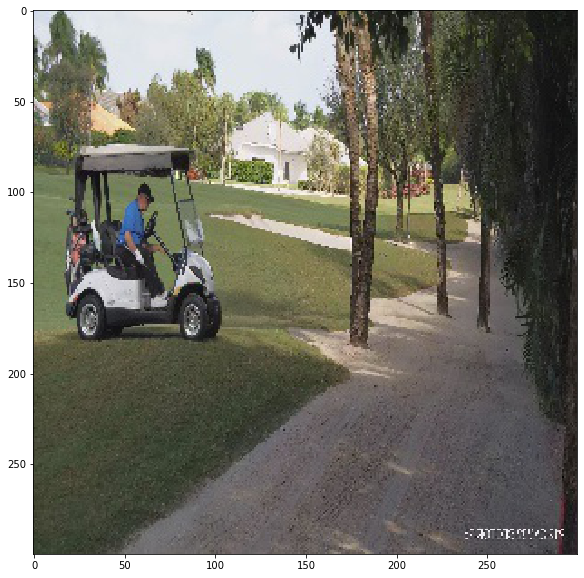

In [42]:
image = caffe.io.load_image('dataset/JPEGImages/32_P12_Cam32_SECTOR_7b_2020_01_09_13_44_09_189_0m13s_mkv0000172_mir_h.JPEG'.format(x))
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [ ]:
##https://stackoverflow.com/questions/30822009/how-to-speed-up-caffe-classifer-in-python

## Net Surgery


In [ ]:
from pylab import *
%matplotlib inline

In [ ]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()

#model_def = 'test/DIT/train2/dit/train_val_all_continue.prototxt'
model_def = 'human_car_deploy.prototxt'
model_weights = '_iter_800000.caffemodel'

net = caffe.Classifier(model_def,      # defines the structure of the model
                       model_weights,
                       mean = np.array( [104, 117, 123], dtype='f4'),
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(104, 3, 224, 224)
                      )

### Don't create augmentated data when predict should give 10x speedup

In [ ]:
for i, x in enumerate(categories):
    for j, y in enumerate(sorted(glob.glob('Data/test/{}/*'.format(x)))):
        #net.blobs['data'].data[...] = transformer.preprocess('data',caffe.io.load_image(y))
        caffe_input = transformer.preprocess('data',caffe.io.load_image(y))
        #oversample false speedup
        prediction = net.predict([caffe_input], oversample=False)   
        output_prob = prediction["prob"][0]  # the output probability vector for the first image in the batch
        print ('predicted class is:', output_prob.argmax())
        
#for f in images:
#    x,y,w,h = f
#    cv2.rectangle(image, (x,y), (x+w,y+h), (0,224,224))            
#    image_rgb = image[y:y+h, x:x+w]
#    caffe_input = cv2.resize(image_rgb, (224, 224)).astype(np.float32)
#dont create augmentated data should give 10x speeup
#prediction = net.predict([caffe_input], oversample=False)   
#output_prob = prediction["prob"][0]  # the output probability vector for the first image in the batch
#print ('predicted class is:', output_prob.argmax())